# Load libraries

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
from random import sample
from gensim.models import Word2Vec
import os
from string import punctuation
from nltk.corpus import stopwords
import nltk
import string
%matplotlib inline

In [55]:
# If not already downloaded, run this once to download wordnet and stopwords
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/panayiotis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/panayiotis/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Global variables

In [38]:
META_DATA_PATH = os.path.join('data', 'cases_metadata.csv')
DATA_DIR = os.path.join('data', 'cases')
NUM_CASES = 1000 # Perform analysis on 1000 cases

# Data loading and cleaning

In [74]:
# Load data
cases = pd.read_csv(META_DATA_PATH)

# Drop all cases with NaNs
cases.dropna(subset=['x_republican'],inplace=True)
cases.dropna(subset=['log_cites'],inplace=True)
# Use subset of cases
# cases = cases.sample(NUM_CASES)
# Display how many NaNs there are per column
# print(cases.isnull().sum())

4562


In [78]:
# Load texts and add to dataframe

texts = []
for caseid in cases.caseid:
    file = [os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if f.endswith(caseid + '.txt')]
    # Make sure you found the right file and is unique
    assert len(file) == 1
    text = open(file[0]).read()
    texts.append(text)
    
cases['text'] = texts
print(cases.head())

      caseid  case_reversed  judge_id    year  x_republican  log_cites  \
5099  X2AK86              1    1316.0  2001.0           0.0   2.397895   
5096  X50MTC              1     739.0  2001.0           1.0   2.079442   
1977  X3CTHD              0     850.0  1951.0           1.0   0.693147   
1215  XABCL8              0     232.0  1979.0           0.0   2.708050   
1718  X3ABOL              0    2162.0  1996.0           1.0   3.135494   

                                                   text  
5099   OPINION BOYCE F. MARTIN, Jr.\n, Chief Judge.\...  
5096   JOHN R. GIBSON , Circuit Judge.\nThe issue be...  
1977   L. HAND , Circuit Judge.\nThis is an appeal f...  
1215   BAILEY BROWN , Chief District Judge.\nThese t...  
1718   OPINION WALLACE , Circuit Judge: The City of ...  


In [86]:
# Data normalization and pre-processing

all_sentences = []

def normalize(text):
    # Lower case
    text = text.lower()
    # Remove whitespace
    text = ' '.join(text.split())
    # Remove weird non-printable characters
    text = ''.join([c for c in text if c in string.printable])
    # Remove punctuation
    translator = str.maketrans('','',punctuation) 
    text = text.translate(translator)
    # Remove stopwords
    stoplist = stopwords.words('english')
    text = ' '.join(word for word in text.split() if word not in stoplist)
    # lematize, need to pass words individually
    text = ' '.join(nltk.WordNetLemmatizer().lemmatize(word) for word in text.split())
    all_sentences.append(text.split())
    return text
                   
# Apply normalization to the text of each case
cases['processed_text'] = cases['text'].apply(normalize)
print(cases.head())

      caseid  case_reversed  judge_id    year  x_republican  log_cites  \
5099  X2AK86              1    1316.0  2001.0           0.0   2.397895   
5096  X50MTC              1     739.0  2001.0           1.0   2.079442   
1977  X3CTHD              0     850.0  1951.0           1.0   0.693147   
1215  XABCL8              0     232.0  1979.0           0.0   2.708050   
1718  X3ABOL              0    2162.0  1996.0           1.0   3.135494   

                                                   text  \
5099   OPINION BOYCE F. MARTIN, Jr.\n, Chief Judge.\...   
5096   JOHN R. GIBSON , Circuit Judge.\nThe issue be...   
1977   L. HAND , Circuit Judge.\nThis is an appeal f...   
1215   BAILEY BROWN , Chief District Judge.\nThese t...   
1718   OPINION WALLACE , Circuit Judge: The City of ...   

                                         processed_text  
5099  opinion boyce f martin jr chief judge december...  
5096  john r gibson circuit judge issue u appeal whe...  
1977  l hand circuit judge

# Word2Vec small window=2

Smaller window we expect similar words to have very similar vectors, even if they don't to the same context (this is not well captured by a small window size)

In [85]:
def train_word2vec(sentences, window):
    w2v = Word2Vec(sentences,
                    workers=10,
                    size=300,
                    min_count=20,
                    window=window,
                    sample=1e-3)
    w2v.init_sims(replace=True)
    return w2v

In [96]:
w2v_small = train_word2vec(all_sentences, 2)
w2v_small.init_sims(replace=True)
w2v_small.save('w2v-small.pkl')
w2v_small.wv.most_similar('case')

[('situation', 0.6267842650413513),
 ('proceeding', 0.5038460493087769),
 ('litigation', 0.500220775604248),
 ('controversy', 0.46203505992889404),
 ('distinguishable', 0.4511649012565613),
 ('event', 0.4451952576637268),
 ('appeal', 0.43351566791534424),
 ('instance', 0.42852669954299927),
 ('briefly', 0.41980624198913574),
 ('moitie', 0.4166962802410126)]

# Word2Vec big window=16

Bigger window we expect words that belong to the same context to have similar words, similar topics would have similar vectors, we can inspect this by looking at the closest vectors to a word

In [97]:
w2v_big = train_word2vec(all_sentences, 16)
w2v_big.init_sims(replace=True)
w2v_big.save('w2v-big.pkl')
w2v_big.wv.most_similar('case')

[('distinguishable', 0.6295070648193359),
 ('instant', 0.6217772960662842),
 ('situation', 0.6216025352478027),
 ('decided', 0.5876038074493408),
 ('controlling', 0.5637916922569275),
 ('moitie', 0.5580907464027405),
 ('re', 0.5386110544204712),
 ('present', 0.5328385829925537),
 ('involved', 0.5301691293716431),
 ('judicata', 0.5274114608764648)]

# Picking a sample of 100 words and visualizing them in two dimensions, to demonstrate the difference between the 2 models

### Use t-SNE to visualize high-dimensional data

In [142]:
def plot_words(words, embedding):
    tsne = TSNE(n_components=2, verbose=1)
    sequence = [embedding[w] for w in words]
    seq_embedded = tsne.fit_transform(sequence)

    plt.figure(figsize=(20, 20))
    for i in range(len(words)):
        x, y = seq_embedded[i, 0], seq_embedded[i, 1]
        plt.scatter(x, y)
        plt.annotate(
            words[i], # annotation text
            xy=(x, y), # which  point to annotate
            xytext=(3, 10),
            textcoords='offset points',
            ha='center', # alignment
            va='center'
        )

    plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.447295
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.519596
[t-SNE] KL divergence after 1000 iterations: 0.334024


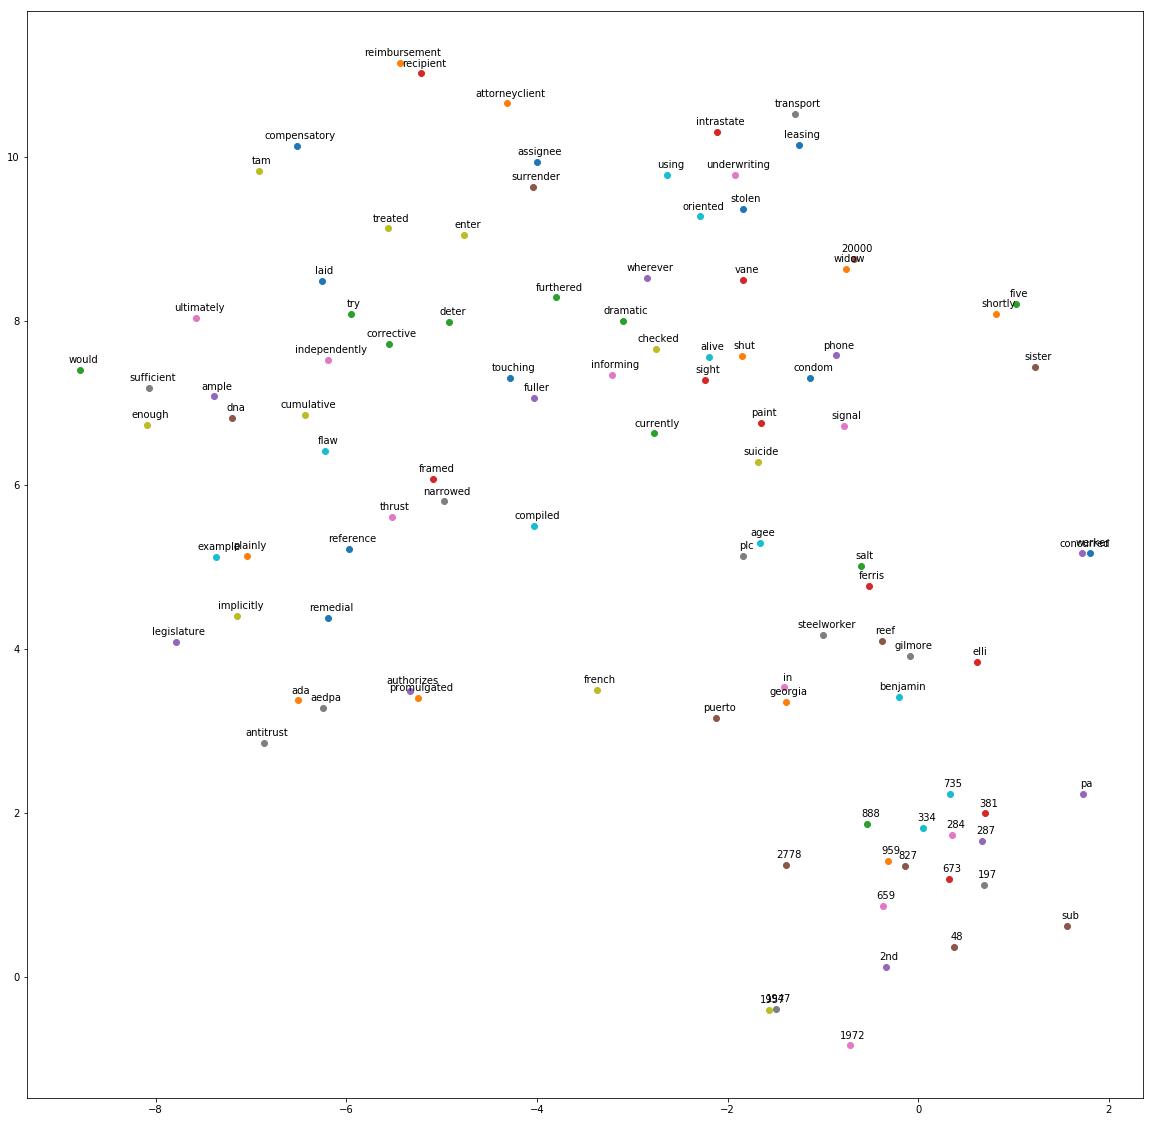

In [143]:
# SMALL window
words_small = sample(w2v_small.wv.index2entity, 100)
plot_words(words_small, w2v_small.wv)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.497208
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.622551
[t-SNE] KL divergence after 1000 iterations: 0.404810


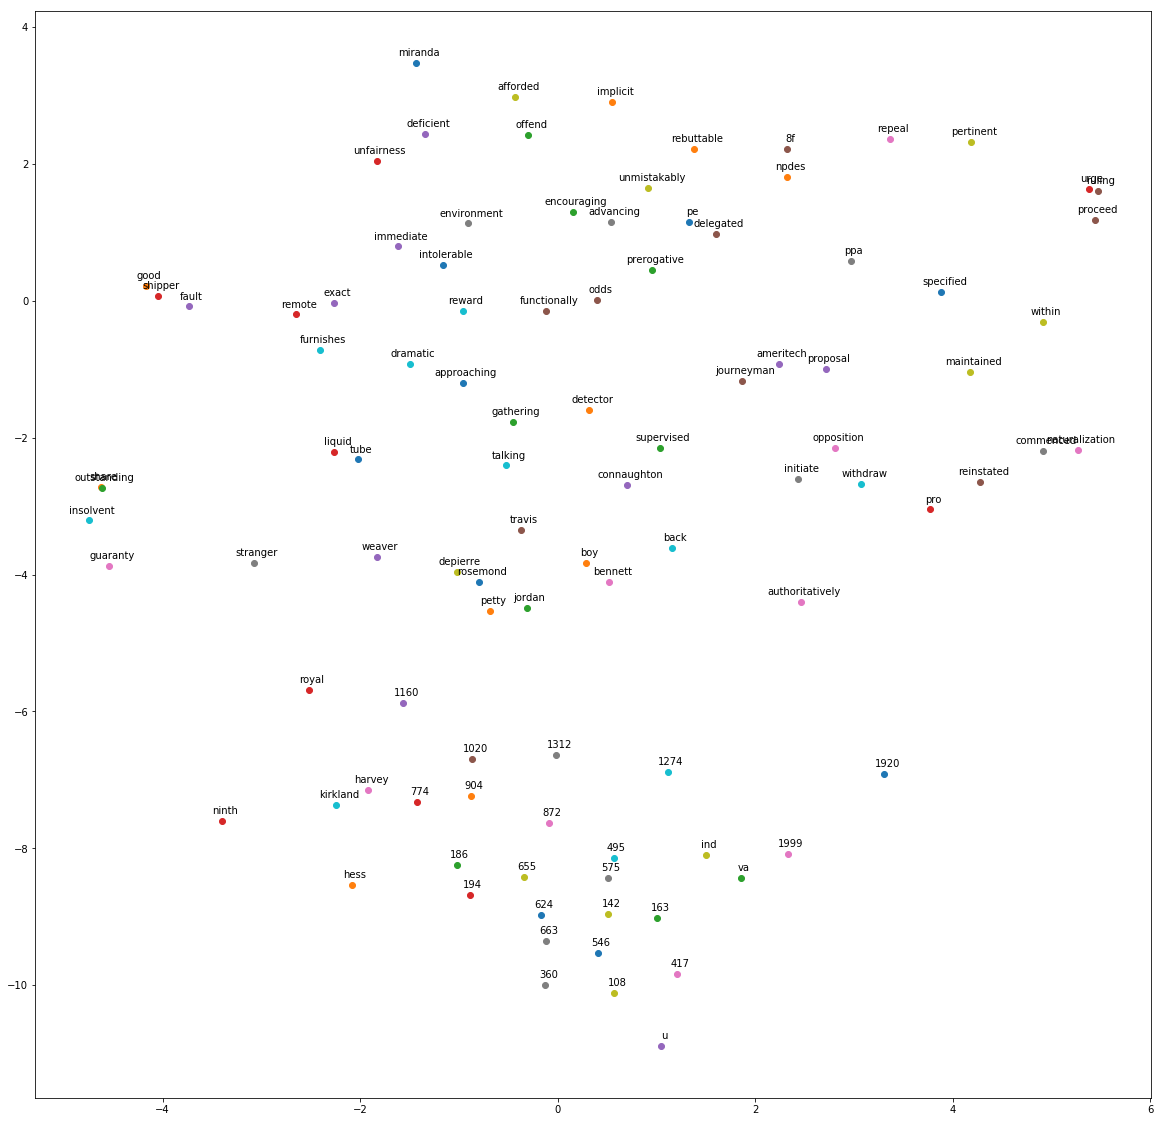

In [144]:
# BIG window
words_big = sample(w2v_big.wv.index2entity, 100)
plot_words(words_big, w2v_big.wv)